In [1]:

from importlib import reload
import os
import pandas as pd
from io import StringIO
import itertools
import ipdb
import datetime
from collections import Counter

import h5py
import json
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

print(tf.__version__)

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM

from keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import mytf.s3utils as msu
import mytf.utils as mu
import mytf.plot as mp

1.14.0


Using TensorFlow backend.


In [2]:
tf.enable_eager_execution()

In [3]:
# Out of curiosity, which cols are not scaled between 0 and 1,
# remove those for training
# Grab and randomize since it's not huge...
vecs = [mu.read_h5_two(source_location='data/2019-12-07-train-balanced.h5', 
                    Xdataset=f'X_{i}',
                    Ydataset=f'Ylabels_{i}')
                 for i in [0, 1, 2, 3]]

X_train = np.concatenate([x[0] for x in vecs])
Ylabels_train = np.concatenate([x[1] for x in vecs])

# shuffle...
size = X_train.shape[0]
print(size)
indices = np.random.choice(range(size), size=size, replace=False)
X_train_shfl = X_train[indices]
Ylabels_train_shfl = Ylabels_train[indices].astype('int64')

34205


In [4]:
X_train_shfl.shape, Ylabels_train_shfl.shape

((34205, 64, 8), (34205,))

In [5]:
Counter(Ylabels_train_shfl)

Counter({0: 9455, 1: 7625, 2: 8286, 3: 8839})

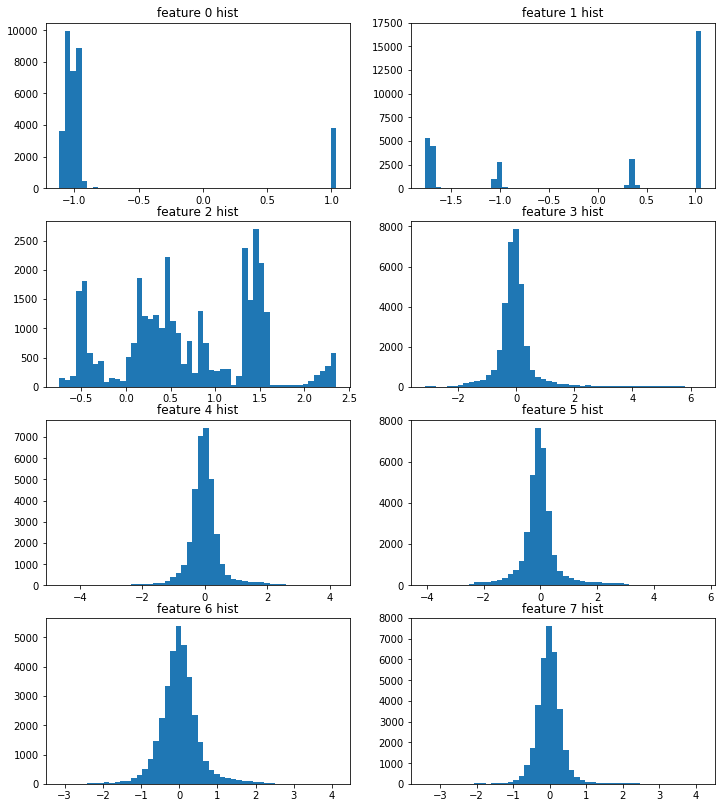

In [12]:
X = X_train_shfl
fig = plt.figure(figsize=(12,14))
for i in range(8):
    ax = fig.add_subplot(int('42' + str(i+1)))
    ax.hist(X[:,0,i], bins=50)
    ax.set(title=f'feature {i} hist')
    
    

In [15]:
# Hmm, per above, data for sure not nicely in same range.
from sklearn.preprocessing import MinMaxScaler
# Doing a quick look at post processed..

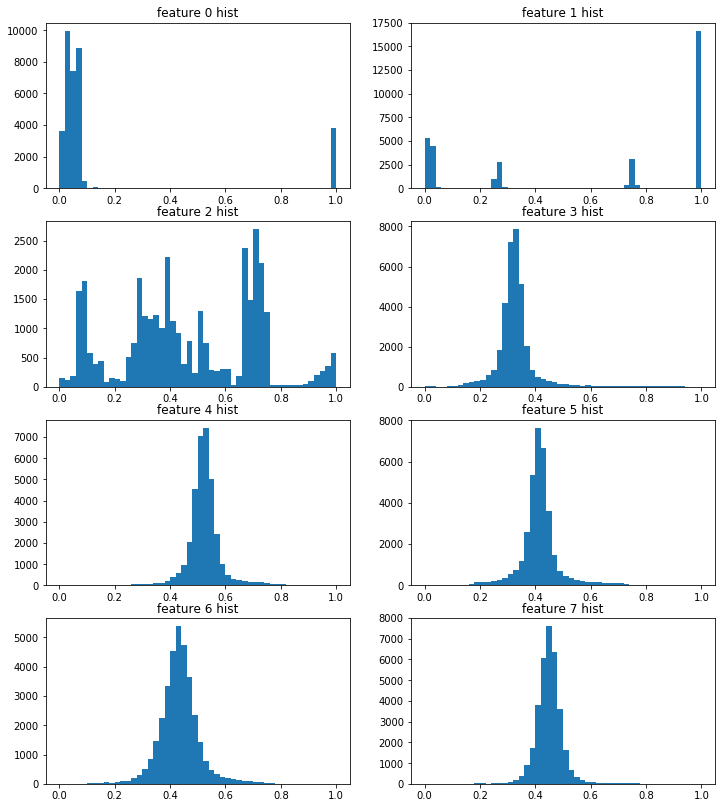

In [21]:
fig = plt.figure(figsize=(12,14))
scalers = {i: MinMaxScaler(feature_range=(0, 1))
          for i in range(8)}

for i in range(8):
    Xscaled = scalers[i].fit_transform(X[:,:,i])
    ax = fig.add_subplot(int('42' + str(i+1)))
    ax.hist(Xscaled[:,0], bins=50)
    ax.set(title=f'feature {i} hist')
    

In [24]:
# Try fit on that ...

X2 = np.concatenate([scalers[0].fit_transform(X[:,:,0]),
scalers[1].fit_transform(X[:,:,1])])
print(Xscaled.shape)
print(X2.shape)

(34205, 64)
(68410, 64)


In [32]:
#np.dstack([scalers[0].fit_transform(X[:,:,0]),
#            scalers[1].fit_transform(X[:,:,1]),
#             scalers[1].fit_transform(X[:,:,2]),
#          ]).shape

scalers = {i: MinMaxScaler(feature_range=(0, 1))
          for i in range(8)}

Xscaled = np.dstack([
            scalers[i].fit_transform(X[:,:,i])
            for i in range(8)])

print(X.shape)
print(Xscaled.shape)
    

(34205, 64, 8)
(34205, 64, 8)


In [33]:
%%time 
# Ok cool... now try it out...
# Did I shuffle? Yes.

X = Xscaled
Ylabels = Ylabels_train_shfl


loss_history = []
validation_loss_history = []
save_dir = 'history'
BATCH_SIZE = 32
ts = mu.quickts(); print('starting,', ts)

size = X_train_shfl.shape[0]
workdir = f'{save_dir}/{ts}'
os.mkdir(workdir)
#Counter(Ylabels_train), Counter(Ylabels_train_shfl)

model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64,   dropout=0.2, recurrent_dropout=0.2,
                batch_input_shape=(None, 64, 8), 
              ),
    # 4 because 'A', 'B', 'C', 'D'.
    tf.keras.layers.Dense(4)])

class_weights = {0: 1., 1: 1., 2: 1., 3: 1.}
# parts = get_partitions(range(size), slice_size=BATCH_SIZE)
# training_indices = np.arange(0, X.shape[0], 1)
dataset_batches = mu.build_dataset_weighty_v3(
        {'x_train': X,
         'ylabels_train': Ylabels},  # 'ylabels_train'  if i have labels
        list(range(size)), 
        class_weights,
        batch_size=BATCH_SIZE)
    
with ipdb.launch_ipdb_on_exception():
    mu.do_train(
        model,
        dataset_batches,
        k=size,
        saveloc=workdir)
#    loss_history_this = [float(x) for x in loss_history_this]
#    loss_history.extend(loss_history_this)
#    #save_loss(loss_history, save_dir)

starting, 2019-12-12T042500Z
num slices 1068
size_remainder,  29


/home/ec2-user/SageMaker/aviation-pilot-physiology-hmm/mytf/utils.py:185: RuntimeWarning: divide by zero encountered in true_divide
  )/class_counts
W1212 04:25:02.915521 140011702228800 deprecation_wrapper.py:119] From /home/ec2-user/SageMaker/aviation-pilot-physiology-hmm/mytf/utils.py:238: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.

0it [00:00, ?it/s]W1212 04:25:03.433110 140011702228800 deprecation_wrapper.py:119] From /home/ec2-user/SageMaker/aviation-pilot-physiology-hmm/mytf/utils.py:246: The name tf.losses.sparse_softmax_cross_entropy is deprecated. Please use tf.compat.v1.losses.sparse_softmax_cross_entropy instead.

W1212 04:25:03.465257 140011702228800 deprecation.py:323] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/losses/losses_impl.py:121: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future v

CPU times: user 8min 3s, sys: 796 ms, total: 8min 4s
Wall time: 8min 6s


In [35]:
ts

'2019-12-12T042500Z'

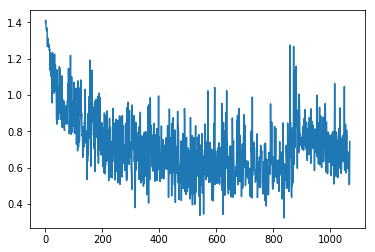

In [36]:
#01068_train_loss_history.json
historydir = 'history'
with open(f'{historydir}/{ts}/01068_train_loss_history.json') as fd:
    losshistory = json.load(fd)
    
plt.plot(losshistory) 

In [37]:
# Hmm, slightly different at the end compared to non scaled. hmm.
os.getpid()

3530

In [39]:
#tf.compat.v1.disable_eager_execution
tf.disable_eager_execution()

In [1]:
# restarted kernel to free up memory... 
# going to proceed to try predict on validation..

In [2]:

from importlib import reload
import os
import pandas as pd
from io import StringIO
import itertools
import ipdb
import datetime
from collections import Counter

import h5py
import json
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

print(tf.__version__)

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM

from keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import mytf.s3utils as msu
import mytf.utils as mu
import mytf.plot as mp

1.14.0


Using TensorFlow backend.


In [3]:
tf.enable_eager_execution()

In [4]:
%%time
dataloc='data/2019-12-07-test-balanced.h5'

X, Ylabels = mu.read_h5_two(dataloc, 'X_0', 'Ylabels_0') 

CPU times: user 21 ms, sys: 21.4 ms, total: 42.4 ms
Wall time: 350 ms


In [10]:
def get_performance_parts(model, dataloc, dataset_names, eager):
    # dataloc contains the test data..
    lossvec = []
    for Xdataset, Ydataset in tqdm(dataset_names):

        X, Ylabels = mu.read_h5_two(dataloc, Xdataset, Ydataset) 
        parts = mu.get_partitions(range(X.shape[0]), 100)
        batchlosses = []
        for part in parts:
            preds = model(X[part].astype('float32'))
            
            if eager:
                tensor = tf.losses.sparse_softmax_cross_entropy(
                        labels=Ylabels[part].astype('int64'),
                        logits=preds.numpy())
                loss = tensor.numpy()
            else:
                tensor = tf.losses.sparse_softmax_cross_entropy(
                        labels=Ylabels[part].astype('int64'),
                        logits=preds)
                loss = tensor.eval()
            batchlosses.append(loss)

        lossvec.append(np.mean(batchlosses))
    return lossvec



# mu.get_performance(model, dataloc, dataset_names)
def perf_wrapper(modelloc, eager):
    model = mu.load_model(modelloc)
    #mu.get_performance(model=model, 
    return get_performance_parts(
                    model=model,
                    dataloc='data/2019-12-07-test-balanced.h5',
                    dataset_names=[['X_0', 'Ylabels_0'],
                                  ['X_1', 'Ylabels_1'],
                                  ['X_2', 'Ylabels_2'],
                                  ['X_3', 'Ylabels_3']],
                    eager=eager)

def json_save(x, loc):
    with open(loc, 'w') as fd:
        json.dump(x, fd)

In [ ]:
%%time
ts = '2019-12-12T042500Z'
batch_losses_vec = []
#sess = tf.Session()
#with sess.as_default():
for step in np.arange(0, 1068, 10):
    print(step)
    modelname = f'history/{ts}/{str(step).zfill(5)}_model.h5'
    print(modelname)
    steploss = perf_wrapper(modelname, eager=True)
    print('steploss, ', steploss)
    batch_losses_vec.append([float(x) for x in steploss])
    json_save(batch_losses_vec, 
              f'history/{ts}/validation_losses.json')


0
history/2019-12-12T042500Z/00000_model.h5


W1212 05:30:05.260590 139865851942720 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:31<01:34, 31.64s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:01<01:02, 31.05s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:40<00:33, 33.60s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:11<00:00, 32.80s/it]


steploss,  [1.198019, 1.364346, 1.5728412, 1.1728513]
10
history/2019-12-12T042500Z/00010_model.h5


W1212 05:32:16.816555 139865851942720 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:31<01:33, 31.17s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:01<01:01, 30.84s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:39<00:32, 32.99s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:11<00:00, 32.76s/it]


steploss,  [1.2170653, 1.3855424, 1.2089025, 1.3909141]
20
history/2019-12-12T042500Z/00020_model.h5


W1212 05:34:28.211450 139865851942720 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:30<01:32, 30.90s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:01<01:01, 30.75s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:39<00:33, 33.02s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:10<00:00, 32.51s/it]


steploss,  [1.3024874, 1.5648806, 0.8183322, 1.8052372]
30
history/2019-12-12T042500Z/00030_model.h5


W1212 05:36:38.704816 139865851942720 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:31<01:34, 31.43s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:02<01:02, 31.42s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:41<00:33, 33.51s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:11<00:00, 32.79s/it]


steploss,  [1.5464047, 1.5345755, 0.5503707, 2.2543929]
40
history/2019-12-12T042500Z/00040_model.h5


W1212 05:38:50.211646 139865851942720 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:31<01:34, 31.58s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:01<01:02, 31.02s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:41<00:33, 33.78s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:11<00:00, 32.87s/it]


steploss,  [1.4195832, 1.3850589, 0.6617284, 1.9703403]
50
history/2019-12-12T042500Z/00050_model.h5


W1212 05:41:02.041283 139865851942720 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:31<01:33, 31.30s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:00<01:01, 30.80s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:39<00:33, 33.08s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:10<00:00, 32.53s/it]


steploss,  [1.3390648, 1.3401526, 0.6749802, 1.9338074]
60
history/2019-12-12T042500Z/00060_model.h5


W1212 05:43:12.791888 139865851942720 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:31<01:33, 31.32s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:00<01:01, 30.82s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:39<00:33, 33.04s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:10<00:00, 32.55s/it]


steploss,  [1.4793999, 1.3103298, 0.48072273, 2.302918]
70
history/2019-12-12T042500Z/00070_model.h5


W1212 05:45:23.332774 139865851942720 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:31<01:33, 31.24s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:02<01:02, 31.26s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:41<00:33, 33.43s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:11<00:00, 32.93s/it]


steploss,  [1.5687792, 1.2839825, 0.41108334, 2.4201863]
80
history/2019-12-12T042500Z/00080_model.h5


W1212 05:47:35.394158 139865851942720 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:31<01:34, 31.37s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:01<01:01, 30.99s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:41<00:33, 33.64s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:11<00:00, 32.92s/it]


steploss,  [1.5088748, 1.0383815, 0.5079243, 2.1762583]
90
history/2019-12-12T042500Z/00090_model.h5


W1212 05:49:47.425726 139865851942720 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:31<01:34, 31.65s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:01<01:02, 31.22s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:41<00:33, 33.76s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:11<00:00, 32.97s/it]


steploss,  [1.4859294, 1.1325045, 0.49086893, 2.2111018]
100
history/2019-12-12T042500Z/00100_model.h5


W1212 05:51:59.645600 139865851942720 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:33<01:40, 33.34s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:03<01:04, 32.35s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:42<00:34, 34.32s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:13<00:00, 33.26s/it]


steploss,  [1.5233594, 0.92984116, 0.54910433, 2.1689637]
110
history/2019-12-12T042500Z/00110_model.h5


W1212 05:54:13.018904 139865851942720 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:31<01:34, 31.56s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:03<01:03, 31.70s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:42<00:33, 33.84s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:13<00:00, 33.32s/it]


steploss,  [1.6958634, 0.8796158, 0.4178429, 2.5304844]
120
history/2019-12-12T042500Z/00120_model.h5


W1212 05:56:26.642980 139865851942720 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:31<01:33, 31.33s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:01<01:02, 31.05s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:40<00:33, 33.32s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:11<00:00, 32.98s/it]


steploss,  [1.7624614, 0.7046031, 0.40632737, 2.6065297]
130
history/2019-12-12T042500Z/00130_model.h5


W1212 05:58:38.896432 139865851942720 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:31<01:33, 31.25s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:01<01:01, 30.89s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:39<00:33, 33.21s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:10<00:00, 32.73s/it]


steploss,  [1.6574184, 0.7721295, 0.40491316, 2.5797954]
140
history/2019-12-12T042500Z/00140_model.h5


W1212 06:00:50.360059 139865851942720 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:33<01:39, 33.29s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:03<01:04, 32.33s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:42<00:34, 34.36s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:12<00:00, 33.24s/it]


steploss,  [1.7690488, 0.67916834, 0.38780057, 2.7002683]
150
history/2019-12-12T042500Z/00150_model.h5


W1212 06:03:03.693491 139865851942720 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:31<01:34, 31.64s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:01<01:02, 31.18s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:41<00:33, 33.83s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:12<00:00, 33.13s/it]


steploss,  [2.102237, 0.37317473, 0.70572644, 2.7675836]
160
history/2019-12-12T042500Z/00160_model.h5


W1212 06:05:16.556186 139865851942720 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:31<01:35, 31.67s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:02<01:02, 31.30s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:40<00:33, 33.46s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:12<00:00, 33.15s/it]


steploss,  [2.1675005, 0.8740491, 2.7525475, 1.9691565]
170
history/2019-12-12T042500Z/00170_model.h5


W1212 06:07:29.493498 139865851942720 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:31<01:33, 31.05s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:01<01:01, 30.84s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:39<00:33, 33.15s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:10<00:00, 32.62s/it]


steploss,  [3.2643895, 0.64530975, 2.908679, 2.4323695]
180
history/2019-12-12T042500Z/00180_model.h5


W1212 06:09:40.328324 139865851942720 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:32<01:36, 32.21s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:02<01:03, 31.67s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:41<00:33, 33.76s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:11<00:00, 32.85s/it]


steploss,  [2.445687, 0.6991801, 0.93385994, 2.6181958]
190
history/2019-12-12T042500Z/00190_model.h5


W1212 06:11:52.080411 139865851942720 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:31<01:34, 31.59s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:01<01:02, 31.13s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:41<00:33, 33.79s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:12<00:00, 33.01s/it]


steploss,  [2.2975516, 0.92020404, 0.55620366, 2.756735]
200
history/2019-12-12T042500Z/00200_model.h5


W1212 06:14:04.451736 139865851942720 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:31<01:34, 31.59s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:01<01:02, 31.19s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:40<00:33, 33.44s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:12<00:00, 33.07s/it]


steploss,  [2.7468452, 0.80424696, 0.9704542, 2.8450682]
210
history/2019-12-12T042500Z/00210_model.h5


W1212 06:16:17.070736 139865851942720 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:31<01:33, 31.25s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:01<01:02, 31.03s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:40<00:33, 33.29s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:11<00:00, 32.80s/it]


steploss,  [2.9947948, 0.7217949, 1.1037825, 3.1464543]
220
history/2019-12-12T042500Z/00220_model.h5


W1212 06:18:28.629104 139865851942720 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:31<01:33, 31.08s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:02<01:02, 31.21s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:41<00:33, 33.49s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:12<00:00, 33.05s/it]


steploss,  [3.7193623, 0.63418037, 2.581578, 3.5419152]
230
history/2019-12-12T042500Z/00230_model.h5


W1212 06:20:41.182470 139865851942720 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:31<01:34, 31.36s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:01<01:02, 31.03s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:41<00:33, 33.73s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:11<00:00, 32.99s/it]


steploss,  [3.7337666, 0.6200397, 2.8475912, 3.6446745]
240
history/2019-12-12T042500Z/00240_model.h5


W1212 06:22:53.497838 139865851942720 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:31<01:35, 31.81s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:01<01:02, 31.24s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:40<00:33, 33.49s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:10<00:00, 32.72s/it]


steploss,  [4.5539494, 0.5744964, 3.5978074, 3.8793123]
250
history/2019-12-12T042500Z/00250_model.h5


W1212 06:25:04.703762 139865851942720 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:32<01:38, 32.76s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:03<01:04, 32.02s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:41<00:33, 33.94s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:12<00:00, 33.08s/it]


steploss,  [4.90741, 0.60671043, 3.8736823, 3.7747889]
260
history/2019-12-12T042500Z/00260_model.h5


W1212 06:27:17.366720 139865851942720 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:31<01:35, 32.00s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:04<01:04, 32.01s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:42<00:33, 33.97s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:13<00:00, 33.48s/it]


steploss,  [4.993663, 0.561847, 3.8905573, 3.8515022]
270
history/2019-12-12T042500Z/00270_model.h5


W1212 06:29:31.644643 139865851942720 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:31<01:34, 31.36s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:01<01:02, 31.12s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:41<00:33, 33.79s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:12<00:00, 33.10s/it]


steploss,  [4.7547655, 0.4695277, 3.655513, 3.9686382]
280
history/2019-12-12T042500Z/00280_model.h5


W1212 06:31:44.408406 139865851942720 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:31<01:34, 31.63s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:01<01:02, 31.08s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:40<00:33, 33.38s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:10<00:00, 32.56s/it]


steploss,  [5.3804255, 0.5032767, 4.197588, 3.9230778]
290
history/2019-12-12T042500Z/00290_model.h5


W1212 06:33:55.002245 139865851942720 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:32<01:38, 32.87s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:02<01:04, 32.00s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:42<00:34, 34.28s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:13<00:00, 33.36s/it]


steploss,  [5.3296547, 0.5672444, 4.2301574, 3.7292676]
300
history/2019-12-12T042500Z/00300_model.h5


W1212 06:36:08.809096 139865851942720 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:31<01:34, 31.58s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:02<01:02, 31.38s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:42<00:33, 33.99s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:13<00:00, 33.44s/it]


steploss,  [5.3423524, 0.5319524, 4.2224536, 3.792785]
310
history/2019-12-12T042500Z/00310_model.h5


W1212 06:38:22.922771 139865851942720 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:31<01:34, 31.41s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:01<01:02, 31.16s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:41<00:33, 33.52s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:13<00:00, 33.27s/it]


steploss,  [5.2740808, 0.4736564, 4.1603546, 3.9422176]
320
history/2019-12-12T042500Z/00320_model.h5


W1212 06:40:36.368865 139865851942720 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:31<01:34, 31.37s/it]

num slices 153
size_remainder,  71


100%|██████████| 4/4 [02:12<00:00, 33.05s/it]


steploss,  [3.5784936, 0.30184078, 2.3301523, 3.4620733]
880
history/2019-12-12T042500Z/00880_model.h5


W1212 08:45:49.289150 139865851942720 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:33<01:40, 33.55s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:03<01:05, 32.53s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:42<00:34, 34.54s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:13<00:00, 33.41s/it]


steploss,  [2.448061, 1.250543, 0.2711832, 5.4226465]
890
history/2019-12-12T042500Z/00890_model.h5


W1212 08:48:03.299982 139865851942720 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:31<01:35, 31.74s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:02<01:02, 31.31s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:42<00:34, 34.03s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:13<00:00, 33.46s/it]


steploss,  [2.2418659, 1.3439867, 0.26024523, 5.069991]
900
history/2019-12-12T042500Z/00900_model.h5


W1212 08:50:17.475387 139865851942720 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:31<01:35, 31.95s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:02<01:03, 31.61s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:41<00:33, 33.82s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:14<00:00, 33.66s/it]


steploss,  [2.3895657, 1.2188742, 0.3338912, 4.9289536]
910
history/2019-12-12T042500Z/00910_model.h5


W1212 08:52:32.452236 139865851942720 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:31<01:35, 31.86s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:02<01:03, 31.50s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:41<00:33, 33.77s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:12<00:00, 33.11s/it]


steploss,  [2.5756335, 1.0975627, 0.36390516, 4.9508038]
920
history/2019-12-12T042500Z/00920_model.h5


W1212 08:54:45.253152 139865851942720 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:33<01:39, 33.22s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:03<01:04, 32.44s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:42<00:34, 34.44s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:13<00:00, 33.29s/it]


steploss,  [2.715047, 1.0323261, 0.3578203, 4.921516]
930
history/2019-12-12T042500Z/00930_model.h5


W1212 08:56:58.761287 139865851942720 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:31<01:35, 31.76s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:01<01:02, 31.23s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:42<00:33, 33.98s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:12<00:00, 33.23s/it]


steploss,  [2.8431818, 1.0229403, 0.33000484, 4.9906716]
940
history/2019-12-12T042500Z/00940_model.h5


W1212 08:59:12.019496 139865851942720 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:31<01:35, 31.76s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:01<01:02, 31.28s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:41<00:33, 33.70s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:13<00:00, 33.45s/it]


steploss,  [2.8315437, 0.9875213, 0.32631665, 4.9856443]
950
history/2019-12-12T042500Z/00950_model.h5


W1212 09:01:26.151828 139865851942720 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:32<01:36, 32.01s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:02<01:03, 31.62s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:41<00:33, 33.88s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:13<00:00, 33.26s/it]


steploss,  [2.8783114, 1.0301887, 0.2755303, 5.1582055]
960
history/2019-12-12T042500Z/00960_model.h5


W1212 09:03:39.548226 139865851942720 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:32<01:37, 32.58s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:03<01:04, 32.07s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:42<00:34, 34.31s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:13<00:00, 33.50s/it]


steploss,  [2.7783153, 0.98680353, 0.29159403, 5.1146817]
970
history/2019-12-12T042500Z/00970_model.h5


W1212 09:05:53.884588 139865851942720 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:32<01:36, 32.17s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:02<01:03, 31.62s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:43<00:34, 34.38s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:14<00:00, 33.59s/it]


steploss,  [2.7892756, 0.99015373, 0.29589275, 5.128487]
980
history/2019-12-12T042500Z/00980_model.h5


W1212 09:08:08.601918 139865851942720 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:31<01:35, 31.95s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:02<01:02, 31.49s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:41<00:33, 33.80s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:13<00:00, 33.46s/it]


steploss,  [2.8927352, 1.0316741, 0.27328026, 5.3048363]
990
history/2019-12-12T042500Z/00990_model.h5


W1212 09:10:22.781208 139865851942720 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:31<01:34, 31.58s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:02<01:02, 31.29s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:41<00:33, 33.64s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:12<00:00, 33.06s/it]


steploss,  [2.8891196, 0.97261065, 0.31990266, 5.2066917]
1000
history/2019-12-12T042500Z/01000_model.h5


W1212 09:12:36.062784 139865851942720 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:31<01:35, 31.71s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:03<01:03, 31.66s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:42<00:33, 33.97s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:13<00:00, 33.35s/it]


steploss,  [2.8377628, 0.9373925, 0.31949943, 5.273577]
1010
history/2019-12-12T042500Z/01010_model.h5


W1212 09:14:49.804447 139865851942720 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:32<01:36, 32.05s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:02<01:03, 31.56s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:42<00:34, 34.24s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:13<00:00, 33.41s/it]


steploss,  [3.027526, 1.0185802, 0.24564831, 5.65989]
1020
history/2019-12-12T042500Z/01020_model.h5


W1212 09:17:03.797455 139865851942720 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:32<01:36, 32.08s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:02<01:03, 31.54s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:41<00:33, 33.79s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:13<00:00, 33.38s/it]


steploss,  [2.9363906, 0.8639914, 0.3106141, 5.285081]
1030
history/2019-12-12T042500Z/01030_model.h5


W1212 09:19:17.657518 139865851942720 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:31<01:35, 31.80s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:02<01:02, 31.48s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:41<00:33, 33.73s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:12<00:00, 33.13s/it]


steploss,  [2.975898, 0.81748825, 0.3250686, 5.324405]
1040
history/2019-12-12T042500Z/01040_model.h5


W1212 09:21:30.545310 139865851942720 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:32<01:36, 32.07s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:04<01:04, 32.04s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:43<00:34, 34.18s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:14<00:00, 33.59s/it]


steploss,  [2.913098, 0.75930834, 0.3528932, 5.1637435]
1050
history/2019-12-12T042500Z/01050_model.h5


W1212 09:23:45.276722 139865851942720 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:31<01:35, 31.95s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:02<01:02, 31.49s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:43<00:34, 34.30s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:14<00:00, 33.50s/it]


steploss,  [2.8153307, 0.6963977, 0.38806453, 4.9756002]
1060
history/2019-12-12T042500Z/01060_model.h5


W1212 09:25:59.643022 139865851942720 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:32<01:36, 32.16s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:02<01:03, 31.57s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:42<00:34, 34.15s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:14<00:00, 33.75s/it]

steploss,  [2.7945762, 0.6863285, 0.4026295, 5.1538343]
CPU times: user 3h 58min 36s, sys: 27 s, total: 3h 59min 3s
Wall time: 3h 58min 9s


In [9]:
type(batch_losses_vec[0][0])

numpy.float32

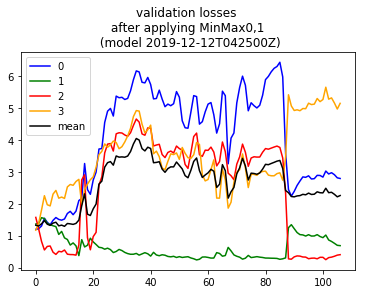

In [13]:
lossesarr = np.array(batch_losses_vec)
meanlossesarr = np.mean(lossesarr, axis=1)

batch_losses_vec[:5]
#batch_losses_vec = []
#for step in np.arange(0, 1068, 10):
# [2.8359528, 0.45356295, 1.7049086, 4.099845]

plt.plot([x[0] for x in batch_losses_vec], color='blue', label='0')
plt.plot([x[1] for x in batch_losses_vec], color='green', label='1')
plt.plot([x[2] for x in batch_losses_vec], color='red', label='2')
plt.plot([x[3] for x in batch_losses_vec], color='orange', label='3')
plt.plot(meanlossesarr, color='black', label='mean')
plt.title(f'validation losses \n after applying MinMax0,1 \n (model {ts})')
plt.legend()
#plt.plot

### 2019-12-13T1504Z
Ahh crap. I forgot to actually use the scalers ... doh hhh
Going to go again

In [1]:
# resurrecting kernel..

In [2]:

from importlib import reload
import os
import pandas as pd
from io import StringIO
import itertools
import ipdb
import datetime
from collections import Counter

import h5py
import json
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

print(tf.__version__)

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM

from keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import mytf.s3utils as msu
import mytf.utils as mu
import mytf.plot as mp

1.14.0


Using TensorFlow backend.


In [3]:
tf.enable_eager_execution()

In [4]:
# Out of curiosity, which cols are not scaled between 0 and 1,
# remove those for training
# Grab and randomize since it's not huge...
vecs = [mu.read_h5_two(source_location='data/2019-12-07-train-balanced.h5', 
                    Xdataset=f'X_{i}',
                    Ydataset=f'Ylabels_{i}')
                 for i in [0, 1, 2, 3]]

X_train = np.concatenate([x[0] for x in vecs])
Ylabels_train = np.concatenate([x[1] for x in vecs])

# shuffle...
size = X_train.shape[0]
print(size)
indices = np.random.choice(range(size), size=size, replace=False)
X_train_shfl = X_train[indices]
Ylabels_train_shfl = Ylabels_train[indices].astype('int64')

34205


In [6]:
X = X_train_shfl
scalers = {i: MinMaxScaler(feature_range=(0, 1))
          for i in range(8)}

Xscaled = np.dstack([
            scalers[i].fit_transform(X[:,:,i])
            for i in range(8)])

print(X.shape)
print(Xscaled.shape)
    

(34205, 64, 8)
(34205, 64, 8)


In [9]:
vars(scalers[0])

{'feature_range': (0, 1),
 'copy': True,
 'n_samples_seen_': 34205,
 'scale_': array([0.46447695, 0.46447695, 0.46447695, 0.46447695, 0.46447695,
        0.46447695, 0.46447695, 0.46447695, 0.46447695, 0.46447695,
        0.46447695, 0.46447695, 0.46447695, 0.46447695, 0.46447695,
        0.46447695, 0.46447695, 0.46447695, 0.46447695, 0.46447695,
        0.46447695, 0.46447695, 0.46447695, 0.46447695, 0.46447695,
        0.46447695, 0.46447695, 0.46447695, 0.46447695, 0.46447695,
        0.46447695, 0.46447695, 0.46447695, 0.46447695, 0.46447695,
        0.46447695, 0.46447695, 0.46447695, 0.46447695, 0.46447695,
        0.46447695, 0.46447695, 0.46447695, 0.46447695, 0.46447695,
        0.46447695, 0.46447695, 0.46447695, 0.46447695, 0.46447695,
        0.46447695, 0.46447695, 0.46447695, 0.46447695, 0.46447695,
        0.46447695, 0.46447695, 0.46447695, 0.46447695, 0.46447695,
        0.46447695, 0.46447695, 0.46447695, 0.46447695]),
 'min_': array([0.51845477, 0.51845477, 0.518454

In [10]:
def scale_multidim(X, scalers):
    # note, hard-coded 8..
    return np.dstack([
            scalers[i].fit_transform(X[:,:,i])
            for i in range(8)])

def get_performance_parts(model, dataloc, dataset_names, 
                          scalers, eager):
    # dataloc contains the test data..
    lossvec = []
    for Xdataset, Ydataset in tqdm(dataset_names):

        X, Ylabels = mu.read_h5_two(dataloc, Xdataset, Ydataset) 
        X = scale_multidim(X, scalers)
        parts = mu.get_partitions(range(X.shape[0]), 100)
        batchlosses = []
        for part in parts:
            preds = model(X[part].astype('float32'))
            
            if eager:
                tensor = tf.losses.sparse_softmax_cross_entropy(
                        labels=Ylabels[part].astype('int64'),
                        logits=preds.numpy())
                loss = tensor.numpy()
            else:
                tensor = tf.losses.sparse_softmax_cross_entropy(
                        labels=Ylabels[part].astype('int64'),
                        logits=preds)
                loss = tensor.eval()
            batchlosses.append(loss)

        lossvec.append(np.mean(batchlosses))
    return lossvec



# mu.get_performance(model, dataloc, dataset_names)
def perf_wrapper(modelloc, scalers, eager):
    model = mu.load_model(modelloc)
    #mu.get_performance(model=model, 
    return get_performance_parts(
                    model=model,
                    dataloc='data/2019-12-07-test-balanced.h5',
                    dataset_names=[['X_0', 'Ylabels_0'],
                                  ['X_1', 'Ylabels_1'],
                                  ['X_2', 'Ylabels_2'],
                                  ['X_3', 'Ylabels_3']],
                    scalers=scalers,
                    eager=eager)

def json_save(x, loc):
    with open(loc, 'w') as fd:
        json.dump(x, fd)

In [ ]:
%%time
ts = '2019-12-12T042500Z'
batch_losses_vec = []
#sess = tf.Session()
#with sess.as_default():
for step in np.arange(0, 1068, 10):
    print(step)
    modelname = f'history/{ts}/{str(step).zfill(5)}_model.h5'
    print(modelname)
    steploss = perf_wrapper(modelname, scalers=scalers, eager=True)
    print('steploss, ', steploss)
    batch_losses_vec.append([float(x) for x in steploss])
    json_save(batch_losses_vec, 
              f'history/{ts}/validation_losses_take2.json')

    
    

0
history/2019-12-12T042500Z/00000_model.h5


W1213 15:34:13.758446 139925391107904 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:31<01:33, 31.31s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:01<01:02, 31.04s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:40<00:33, 33.32s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:11<00:00, 32.85s/it]


steploss,  [1.5023754, 1.4234219, 1.4403098, 1.2357361]
10
history/2019-12-12T042500Z/00010_model.h5


W1213 15:36:25.486160 139925391107904 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:31<01:34, 31.66s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:03<01:03, 31.73s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:42<00:33, 33.87s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:13<00:00, 33.37s/it]


steploss,  [1.5108212, 1.2929059, 1.4089382, 1.5404227]
20
history/2019-12-12T042500Z/00020_model.h5


W1213 15:38:39.320807 139925391107904 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:31<01:34, 31.42s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:01<01:02, 31.01s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:42<00:33, 33.97s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:12<00:00, 33.19s/it]


steploss,  [1.4693539, 1.3959935, 1.2843101, 2.0912068]
30
history/2019-12-12T042500Z/00030_model.h5


W1213 15:40:52.411744 139925391107904 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:31<01:34, 31.65s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:01<01:02, 31.08s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:40<00:33, 33.50s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:11<00:00, 32.75s/it]


steploss,  [1.8135517, 1.1932424, 0.97344965, 2.7193756]
40
history/2019-12-12T042500Z/00040_model.h5


W1213 15:43:03.764403 139925391107904 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:32<01:38, 32.87s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:02<01:04, 32.01s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:41<00:34, 34.13s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:12<00:00, 33.12s/it]


steploss,  [2.217035, 0.83560526, 1.4195698, 2.6147232]
50
history/2019-12-12T042500Z/00050_model.h5


W1213 15:45:16.720756 139925391107904 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:31<01:33, 31.23s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:02<01:02, 31.30s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:40<00:33, 33.36s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:11<00:00, 32.89s/it]


steploss,  [2.6017618, 0.8244144, 1.9907942, 2.5329676]
60
history/2019-12-12T042500Z/00060_model.h5


W1213 15:47:28.606983 139925391107904 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:31<01:33, 31.01s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:01<01:01, 30.90s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:40<00:33, 33.25s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:12<00:00, 33.06s/it]


steploss,  [2.8235352, 1.0062063, 2.4849072, 2.603332]
70
history/2019-12-12T042500Z/00070_model.h5


W1213 15:49:41.194801 139925391107904 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:31<01:35, 31.81s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:02<01:02, 31.35s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:40<00:33, 33.54s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:11<00:00, 32.77s/it]


steploss,  [3.161837, 1.0411537, 3.1192865, 2.6367316]
80
history/2019-12-12T042500Z/00080_model.h5


W1213 15:51:52.612290 139925391107904 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:33<01:40, 33.52s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:03<01:04, 32.45s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:42<00:34, 34.34s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:12<00:00, 33.18s/it]


steploss,  [3.80499, 0.7860932, 3.6440794, 2.4185634]
90
history/2019-12-12T042500Z/00090_model.h5


W1213 15:54:05.688757 139925391107904 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:31<01:35, 31.69s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:01<01:02, 31.17s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:41<00:33, 33.82s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:12<00:00, 33.07s/it]


steploss,  [2.6013594, 1.1905224, 2.264198, 2.4115503]
100
history/2019-12-12T042500Z/00100_model.h5


W1213 15:56:18.473033 139925391107904 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:31<01:33, 31.03s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:01<01:01, 30.74s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:38<00:32, 32.84s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:10<00:00, 32.65s/it]


steploss,  [2.9511018, 1.1874528, 2.606476, 2.435904]
110
history/2019-12-12T042500Z/00110_model.h5


W1213 15:58:29.434708 139925391107904 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:31<01:33, 31.09s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:01<01:01, 30.77s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:40<00:33, 33.31s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:11<00:00, 32.82s/it]


steploss,  [3.5617008, 1.5209672, 3.3498764, 3.0511699]
120
history/2019-12-12T042500Z/00120_model.h5


W1213 16:00:41.036432 139925391107904 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:33<01:39, 33.21s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:03<01:04, 32.27s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:42<00:34, 34.33s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:12<00:00, 33.17s/it]


steploss,  [4.5414815, 1.4333903, 4.12359, 2.8774326]
130
history/2019-12-12T042500Z/00130_model.h5


W1213 16:02:54.070659 139925391107904 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:31<01:35, 31.68s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:01<01:02, 31.17s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:42<00:33, 33.97s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:13<00:00, 33.29s/it]


steploss,  [4.5528126, 1.2162617, 3.8711355, 2.5097532]
140
history/2019-12-12T042500Z/00140_model.h5


W1213 16:05:07.597490 139925391107904 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:31<01:34, 31.49s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:01<01:02, 31.05s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:40<00:33, 33.32s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:12<00:00, 33.02s/it]


steploss,  [4.8577366, 1.3790438, 4.347193, 2.8137279]
150
history/2019-12-12T042500Z/00150_model.h5


W1213 16:07:20.050237 139925391107904 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:31<01:33, 31.12s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:01<01:01, 30.92s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:39<00:33, 33.04s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:10<00:00, 32.52s/it]


steploss,  [5.557324, 1.5427483, 4.9489236, 3.2638264]
160
history/2019-12-12T042500Z/00160_model.h5


W1213 16:09:30.479714 139925391107904 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:30<01:32, 30.97s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:02<01:02, 31.28s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:42<00:33, 33.62s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:12<00:00, 33.22s/it]


steploss,  [5.102355, 1.4873643, 4.698047, 3.2738988]
170
history/2019-12-12T042500Z/00170_model.h5


W1213 16:11:43.887542 139925391107904 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:32<01:36, 32.25s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:02<01:03, 31.66s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:42<00:34, 34.23s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:13<00:00, 33.31s/it]


steploss,  [5.2030325, 0.90786517, 4.710816, 3.0922334]
180
history/2019-12-12T042500Z/00180_model.h5


W1213 16:13:57.496211 139925391107904 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:32<01:37, 32.39s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:02<01:03, 31.73s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:41<00:34, 34.01s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:12<00:00, 33.23s/it]


steploss,  [4.644016, 1.3350837, 3.8488548, 2.8807597]
190
history/2019-12-12T042500Z/00190_model.h5


W1213 16:16:10.892282 139925391107904 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:32<01:38, 32.69s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:03<01:04, 32.10s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:42<00:34, 34.14s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:13<00:00, 33.47s/it]


steploss,  [4.6174674, 1.3379534, 3.7934682, 3.0033016]
200
history/2019-12-12T042500Z/00200_model.h5


W1213 16:18:25.126502 139925391107904 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:31<01:35, 31.94s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:03<01:03, 31.96s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:43<00:34, 34.19s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:14<00:00, 33.65s/it]


steploss,  [5.1563916, 1.3058459, 4.3778687, 3.1361783]
210
history/2019-12-12T042500Z/00210_model.h5


W1213 16:20:40.090506 139925391107904 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:32<01:36, 32.14s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:02<01:03, 31.65s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:44<00:34, 34.58s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:14<00:00, 33.67s/it]


steploss,  [5.6695967, 1.5259678, 4.8658104, 3.567818]
220
history/2019-12-12T042500Z/00220_model.h5


W1213 16:22:55.123541 139925391107904 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:32<01:36, 32.09s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:02<01:03, 31.52s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:42<00:34, 34.07s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:13<00:00, 33.40s/it]


steploss,  [6.135114, 1.6508763, 5.278801, 3.664861]
230
history/2019-12-12T042500Z/00230_model.h5


W1213 16:25:09.088269 139925391107904 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:32<01:38, 32.84s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:03<01:04, 32.18s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:42<00:34, 34.36s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:14<00:00, 33.65s/it]


steploss,  [6.1238976, 1.6728871, 5.3211317, 3.563007]
240
history/2019-12-12T042500Z/00240_model.h5


W1213 16:27:24.067989 139925391107904 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:32<01:37, 32.47s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:04<01:04, 32.45s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:43<00:34, 34.45s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:14<00:00, 33.72s/it]


steploss,  [6.410138, 1.6494111, 5.513445, 3.4494774]
250
history/2019-12-12T042500Z/00250_model.h5


W1213 16:29:39.284635 139925391107904 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:32<01:36, 32.15s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:02<01:03, 31.76s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:43<00:34, 34.51s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:14<00:00, 33.60s/it]


steploss,  [6.516136, 1.6136757, 5.62877, 3.4227421]
260
history/2019-12-12T042500Z/00260_model.h5


W1213 16:31:54.031491 139925391107904 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:32<01:36, 32.25s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:02<01:03, 31.63s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:42<00:34, 34.09s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:13<00:00, 33.28s/it]


steploss,  [6.498629, 1.745919, 5.6714125, 3.7742705]
270
history/2019-12-12T042500Z/00270_model.h5


W1213 16:34:07.525166 139925391107904 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:34<01:42, 34.19s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:04<01:06, 33.14s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:43<00:34, 34.91s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:15<00:00, 33.87s/it]


steploss,  [6.5849495, 1.6617786, 5.644706, 3.390805]
280
history/2019-12-12T042500Z/00280_model.h5


W1213 16:36:23.352676 139925391107904 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:31<01:35, 31.85s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:04<01:04, 32.10s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:44<00:34, 34.32s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:15<00:00, 33.89s/it]


steploss,  [6.798399, 1.6832389, 5.774742, 3.5486763]
290
history/2019-12-12T042500Z/00290_model.h5


W1213 16:38:39.253143 139925391107904 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:31<01:35, 31.72s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:01<01:02, 31.26s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:43<00:34, 34.35s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:14<00:00, 33.57s/it]


steploss,  [6.9022193, 1.7994953, 5.8683233, 3.9211223]
300
history/2019-12-12T042500Z/00300_model.h5


W1213 16:40:53.885153 139925391107904 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:32<01:36, 32.06s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:02<01:02, 31.49s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:41<00:33, 33.94s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:12<00:00, 33.16s/it]


steploss,  [7.005372, 1.6659633, 5.908651, 3.4806132]
310
history/2019-12-12T042500Z/00310_model.h5


W1213 16:43:06.893375 139925391107904 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:33<01:39, 33.24s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:04<01:05, 32.60s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:44<00:34, 34.78s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:15<00:00, 33.87s/it]


steploss,  [6.9188504, 1.6695428, 5.872718, 3.5303752]
320
history/2019-12-12T042500Z/00320_model.h5


W1213 16:45:22.740390 139925391107904 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:31<01:35, 31.69s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:04<01:04, 32.03s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:44<00:34, 34.30s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:15<00:00, 33.79s/it]


steploss,  [6.953392, 1.7162308, 5.8595314, 3.754967]
330
history/2019-12-12T042500Z/00330_model.h5


W1213 16:47:38.267718 139925391107904 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:31<01:35, 31.98s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:02<01:03, 31.66s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:43<00:34, 34.49s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:14<00:00, 33.73s/it]


steploss,  [7.158637, 1.681675, 5.96891, 3.7661426]
340
history/2019-12-12T042500Z/00340_model.h5


W1213 16:49:53.790786 139925391107904 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:32<01:37, 32.35s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:02<01:03, 31.73s/it]

num slices 197
size_remainder,  55


 75%|███████▌  | 3/4 [01:41<00:33, 34.00s/it]

num slices 155
size_remainder,  42


100%|██████████| 4/4 [02:13<00:00, 33.29s/it]


steploss,  [7.414079, 1.7246228, 6.090462, 4.0863824]
350
history/2019-12-12T042500Z/00350_model.h5


W1213 16:52:07.322741 139925391107904 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
  0%|          | 0/4 [00:00<?, ?it/s]

num slices 160
size_remainder,  80


 25%|██▌       | 1/4 [00:33<01:40, 33.47s/it]

num slices 153
size_remainder,  71


 50%|█████     | 2/4 [01:04<01:05, 32.68s/it]

num slices 197
size_remainder,  55


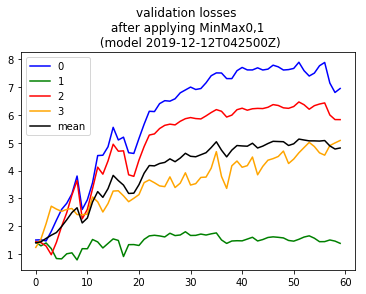

In [5]:
# kernel died in meantime hmm , 
import json
import matplotlib.pyplot as plt
import numpy as np
ts = '2019-12-12T042500Z'

with open(f'history/{ts}/validation_losses_take2.json') as fd:
    batch_losses_vec = json.load(fd)
    
lossesarr = np.array(batch_losses_vec)
meanlossesarr = np.mean(lossesarr, axis=1)

batch_losses_vec[:5]
#batch_losses_vec = []
#for step in np.arange(0, 1068, 10):
# [2.8359528, 0.45356295, 1.7049086, 4.099845]

plt.plot([x[0] for x in batch_losses_vec], color='blue', label='0')
plt.plot([x[1] for x in batch_losses_vec], color='green', label='1')
plt.plot([x[2] for x in batch_losses_vec], color='red', label='2')
plt.plot([x[3] for x in batch_losses_vec], color='orange', label='3')
plt.plot(meanlossesarr, color='black', label='mean')
plt.title(f'validation losses \n after applying MinMax0,1 \n (model {ts})')
plt.legend()
#plt.plot


In [6]:
# ok even though I applied that scaling bit to test set this time,
# this is still deteriorating validation loss.